# Local Volatility Model
------------------
> **Idriss Afra**

This project aims to implement the Local Volatility model.

## Model Description
The Local Volatility model assumes the following SDE under the risk-neutral measure :   

$$
dS_t = (r_t - q_t) \times S_t \times dt + \sigma(t, S_t) \times S_t \times dW_t
$$

Where $S_t$ is the stock or index price, $r_t$ is the deterministic instantaneous forward interest rate, $q_t$ is the deterministic instantaneous forward dividend yield, $\sigma(t, S_t)$ is the deterministic local volatility function, and $W_t$ is a standard brownian motion.

The European call option price $C(T, K)$ satisfies the following forward Kolmogorov PDE :    

$$
\frac{dC}{dT} + \left(r_T - q_T\right)K\frac{dC}{dK}-\frac{1}{2}\sigma^2(T, K)K^2\frac{d^2C}{dK^2} + q_TC = 0
$$

Which implies the Dupire equation :     

$$
\sigma^2(T, K) = 2\times\frac{\frac{dC}{dT} + \left(r_T - q_T\right)K\frac{dC}{dK} + q_TC}{K^2\frac{d^2C}{dK^2}}
$$

By computing total derivatives, we end up with the below stripping formula used to calibrate the Local Volatility function :

$$
\sigma^2(t=T, S_t=K) = \frac{\frac{\hat{\sigma}}{T} + 2\frac{d\hat{\sigma}}{dT} + 2\left(r_T - q_T\right)K\frac{d\hat{\sigma}}{dK}}{K^2\left( \frac{d^2\hat{\sigma}}{dK^2} - \sqrt{T} d_1 \left(\frac{d\hat{\sigma}}{dK}\right)^2 + \frac{1}{\hat{\sigma}} \left( \frac{1}{\sqrt{T}K} + d_1 \frac{d\hat{\sigma}}{dK} \right)^2\right)}
$$


<br> Where $\hat{\sigma}(T, K)$ is the Black-Scholes implied volatility, and $d_1 = \frac{log\left(F / K\right) + \hat{\sigma}^2 T / 2}{\hat{\sigma} \sqrt{T}}$.

##Market Data : META US Equity
Let us calibrate the Local Volatility model on Meta US Equity European Options asof October 18th 2023.

In [1]:
from datetime import date
import numpy as np

now_date = date(2023, 10, 18)

# Meta US Equity Data :

# Spot Price
S0 = 316.97

# Listed Options Tenors and Forward prices up to those Tenors (Meta US does not pay Dividends)
tenors = np.array([date(2023, 11, 3), date(2023, 11, 17), date(2023, 12, 15), date(2024, 1, 19), date(2024, 2, 16)])
fwds = np.array([317.05, 317.67, 318.9, 320.584, 321.943])

# Data of the three first Tenor : Listed Options Strikes, Flavors, and Prices
st_strikes = np.array([300, 305, 310, 315, 320, 325])
st_flavors = np.array(["Put"] * 4 + ["Call"] * 2)
prices_1 = [9, 10.8, 12.875, 15.175, 14.775, 12.6]
prices_2 = [10.95, 12.8, 14.9, 17.2, 17.4, 15.2]
prices_3 = [13.775, 15.675, 17.8, 20.1, 21.5, 19.2]

# Data of the last two Tenors : Listed Options Strikes, Flavors, and Prices
lt_strikes = np.array([300, 305, 310, 315, 320, 325, 330])
lt_flavors = np.array(["Put"] * 5 + ["Call"] * 2)
prices_4 = [16.91, 18.86, 21.016, 23.3, 25.761, 24, 21.85]
prices_5 = [21.25, 23.3, 25.475, 27.775, 30.225, 29.8, 27.575]

strikes = np.array([st_strikes, st_strikes, st_strikes, lt_strikes, lt_strikes], dtype=object)
flavors = np.array([st_flavors, st_flavors, st_flavors, lt_flavors, lt_flavors], dtype=object)
prices = np.array([prices_1, prices_2, prices_3, prices_4, prices_5], dtype=object)

## Market Implied Volatilities : Black-Scholes Model
The Equity listed options are quoted in prices and not in volatilities. Therefore, market volatilities need to be implied using numerical methods.

We use the Newton-Raphson algorithm to find the root $\hat{\sigma}(K_{market}, T_{market})$ of the following equation :

$$
BS(F_0, K_{market}, \hat{\sigma}(K_{market}, T_{market}), T) - MarketPrice(K_{market}, T_{market}) = 0
$$

In [2]:
from scipy.stats import norm
import math

def black_scholes(flavor, K, T, S, r, vol, q=0) :
  """
  The Black-Scholes price.
  """
  v2T = vol**2 * T
  d1 = (math.log(S/K) + (r - q) * T + v2T / 2) / v2T**0.5
  d2 = d1 - v2T**0.5
  phi = 1 if flavor.upper() == "CALL" else  -1
  return phi * (S * math.exp(-q * T) * norm.cdf(phi * d1) - K * math.exp(-r * T) * norm.cdf(phi * d2))

def vega_bs(K, T, S, r, vol, q=0) :
  """
  The Black-Scholes Vega greek : The derivative of the option value with respect to the volatility of the underlying asset.
  """
  v2T = vol**2 * T
  d2 = (math.log(S/K) + (r - q) * T - v2T / 2) / v2T**0.5
  return K * math.exp(-r * T) * norm.pdf(d2) * T**0.5

In [3]:
import sys

def newton_raphson(market_price, init_vol, flavor, K, T, S, r, q=0):
  """
  The Newton-Raphson algorithm : Implied volatilities from market prices
  """
  eps = 1e-07
  vol = init_vol
  func = black_scholes(flavor, K, T, S, r, vol, q) - market_price
  func_deriv = vega_bs(K, T, S, r, vol, q)
  error = sys.exit("The algorithm failed to converge. Please review the input data.") if func_deriv < 0.0001 else "No error."
  next_vol = vol - func / func_deriv
  error = sys.exit("The algorithm failed to converge. Please review the input data.") if next_vol < 0.0001 else "No error."
  nb_iteration = 1
  while abs(next_vol - vol) > eps :
    vol = next_vol
    func = black_scholes(flavor, K, T, S, r, vol, q) - market_price
    func_deriv = vega_bs(K, T, S, r, vol, q)
    error = sys.exit("The algorithm failed to converge. Please review the input data.") if func_deriv < 0.0001 else "No error."
    next_vol = vol - func / func_deriv
    error = sys.exit("The algorithm failed to converge. Please review the input data.") if next_vol < 0.0001 else "No error."
    nb_iteration += 1
    error = sys.exit("The algorithm failed to converge. Please review the input data.") if nb_iteration > 300 else "No error."

  return next_vol

In [4]:
# Newton-Raphson Algorithm Results :

implied_vols_surface = []

print("Implied Market (BS) Volatilities :")
print("---------------------------------------")

for t in range(len(tenors)) :
  implied_vols = []
  T = (tenors[t] - now_date).days / 365

  for k in range(len(strikes[t])) :
    implied_vols.append(newton_raphson(prices[t][k], 0.4, flavors[t][k], strikes[t][k], T, S0, (np.log(fwds / S0) / T)[t]))

  print("Implied Volatilities up to {} : {}".format(tenors[t], [round(vol, 4) for vol in implied_vols]))
  implied_vols_surface.append(implied_vols)

implied_vols_surface = np.array(implied_vols_surface, dtype=object)

Implied Market (BS) Volatilities :
---------------------------------------
Implied Volatilities up to 2023-11-03 : [0.6258, 0.6209, 0.6175, 0.6135, 0.6097, 0.6072]
Implied Volatilities up to 2023-11-17 : [0.5238, 0.5194, 0.5163, 0.513, 0.51, 0.5085]
Implied Volatilities up to 2023-12-15 : [0.4484, 0.4446, 0.442, 0.4394, 0.4371, 0.4348]
Implied Volatilities up to 2024-01-19 : [0.4189, 0.4157, 0.4136, 0.4111, 0.4092, 0.4072, 0.4059]
Implied Volatilities up to 2024-02-16 : [0.4401, 0.4375, 0.435, 0.4326, 0.4305, 0.4287, 0.4268]


## SABR Fitting Method
To strip the Local Volatility surface, we need to compute the below derivatives :     

$\frac{d\hat{\sigma}}{dT} = \frac{\hat{\sigma}(K, T+dT) - \hat{\sigma}(K, T)}{dT}$  

$\frac{d\hat{\sigma}}{dK} = \frac{\hat{\sigma}(K + dK, T) - \hat{\sigma}(K, T)}{dK}$

$\frac{d^2\hat{\sigma}}{dK^2} = \frac{\hat{\sigma}(K + dK, T) + \hat{\sigma}(K-dK, T) - 2\hat{\sigma}(K, T)}{dK^2}$

To do so, we must fit the market volatilities and imply $\hat{\sigma}(K, T)$ for every $T, K > 0$.
<br>We use the SABR fitting method in this project. However, since SABR does not correct implied market Arbitrages and can create new arbitrages for very low and large strikes, arbitrages cleaning on market prices is required. Moreover, it would be safer to strip the local volatility between chosen min/max strikes and maturities and then apply extrapolation methods, or better, use SVI fitting methods and strip the local volatility through the V2T version of Dupire equation. 

In [5]:
import numpy as np

def sabr_vol(T, K, F0, sigma0, alpha, rho, beta=0.3) :
  """
  Hagan's 2002 SABR log-normal vol expansion.
  The strike K can be a scalar or an array, the function will return an array
  of log-normal vols.
  """
  eps = 1e-04
  fk_beta = (F0 * K)**(1 - beta)
  log_fk = np.log(F0/K)

  a = ((1 - beta)**2 / 24) * (sigma0**2 / fk_beta)
  b = 0.25 * rho * beta * alpha * sigma0 / fk_beta**0.5
  c = (2 - 3 * rho**2) * alpha**2 / 24
  d = fk_beta**0.5
  e = (1 - beta)**2 * log_fk**2 / 24
  f = (1 - beta)**4 * log_fk**4 / 1920
  z = alpha * fk_beta**0.5 * log_fk / sigma0

  # For close points to ATM, z and x(z) become close to zero and should be removed for the Hagan's formula
  num = sigma0 * (1 + (a + b + c) * T)
  num = np.where(abs(z) > eps, num * z, num)
  den = d * (1 + e + f)
  den = np.where(abs(z) > eps, den * x(rho, z), den)

  return num / den

def x(rho, z) :
  """
  Return function x used in Hagan's 2002 SABR log-normal vol expansion.
  """
  num = (1 - 2 * rho * z + z**2)**0.5 + z - rho
  den = 1 - rho
  return  np.log (num / den)


In [6]:
from scipy.optimize import minimize

def sabr_calibration(T, F0, strikes, vol_market, beta = 0.3) :
  """
  SABR model calibration : Sigma0, Alpha, and Rho.
  """
  parameters0 = np.array([vol_market[len(vol_market) // 2], 0.2, -0.2]) # vol_market[len(vol_market) // 2] is the closest point vol to ATM, 0.2 and -0.2 were chosen arbitrary
  res = minimize(obj_func, x0=parameters0, args=(T, F0, strikes, vol_market, beta), bounds=((0.01, None), (0.01, None), (-0.99, 0.99)))
  return res.x

def obj_func(parameters, T, F0, strikes, vol_market, beta) :
  """
  The Sum Squared Error function : Used as the objective function in the SABR Calibration.
  """
  sabr_volatilities = sabr_vol(T, strikes, F0, parameters[0], parameters[1], parameters[2], beta)
  sse = 0
  for i in range(len(strikes)) :
    sse += (sabr_volatilities[i] - vol_market[i])**2
  return sse


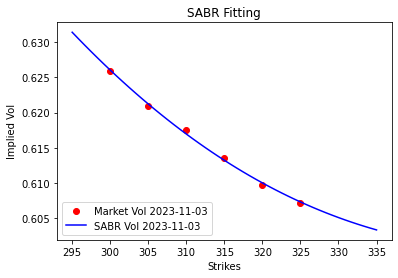

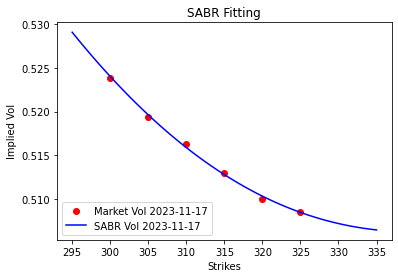

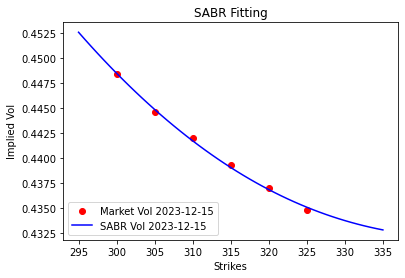

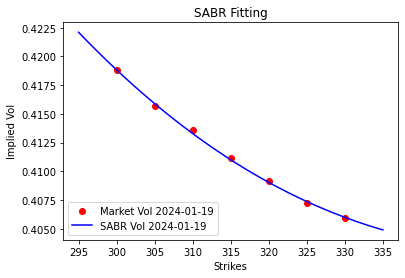

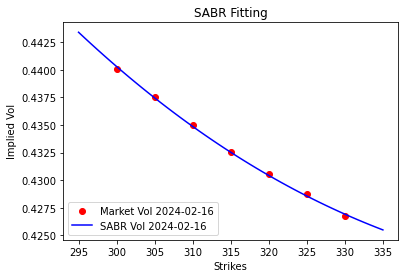

In [7]:
import matplotlib.pyplot as plt

# SABR Calibration Results :

sabr_params = []
for t in range(len(tenors)) :
  T = (tenors[t] - now_date).days / 365
  sabr_params.append(sabr_calibration(T, fwds[t], strikes[t], implied_vols_surface[t]))

sabr_params = np.array(sabr_params, dtype=object)

x_axis = np.linspace(strikes[-1][0] - 5, strikes[-1][-1] + 5, 49)

for t in range(len(tenors)) :
  plt.title("SABR Fitting")
  plt.ylabel("Implied Vol")
  plt.xlabel("Strikes")
  plt.scatter(strikes[t], implied_vols_surface[t], color="red", label="Market Vol " + str(tenors[t]))
  T = (tenors[t] - now_date).days / 365
  plt.plot(x_axis, sabr_vol(T, x_axis, fwds[t], sabr_params[t][0], sabr_params[t][1], sabr_params[t][2]), color="blue", label="SABR Vol " + str(tenors[t]))
  plt.legend(loc="lower left")
  plt.show()

##The Stripping Algorithm
The Hagan's Expansion Volatility formula allows us to compute $\hat{\sigma}(K, T_{market})$ for every $K>0$ under the SABR.
<br>On the other hand, we can interpolate the SABR parameters to compute $\hat{\sigma}(K, T)$ for every $T>0$

In [8]:
from scipy.interpolate import interp1d, PchipInterpolator

# Interpolation functions of the SABR parameters : Monotonic Cubic Interpolation
sigma = [sabr_params[i][0] for i in range(len(tenors))]
alpha = [sabr_params[i][1] for i in range(len(tenors))]
rho = [sabr_params[i][2] for i in range(len(tenors))]
vol_tenors = [(tenors[i] - now_date).days / 365 for i in range(len(tenors))]
sigma_interp = PchipInterpolator(vol_tenors, sigma, extrapolate=True)
alpha_interp = PchipInterpolator(vol_tenors, alpha, extrapolate=True)
rho_interp = PchipInterpolator(vol_tenors, rho, extrapolate=True)

# Implied ZC Rates from Forward Prices : Cubic Interpolation
zc_rates = [math.log(fwds[i] / S0) / vol_tenors[i] for i in range(len(tenors))]
zc_rates_interp = interp1d(vol_tenors, zc_rates, kind='cubic', fill_value="extrapolate")

# Discount Factors
df = S0 / fwds

In [9]:
def implied_vol_sabr(T, K) :
  """
  SABR Implied vol : Time dependent Monotonic Cubic interpolation of the SABR parameters.
  """
  F0 = S0 * np.exp(zc_rates_interp(T) * T)
  sigma0 = sigma_interp(T)
  alpha = alpha_interp(T)
  rho = rho_interp(T)
  return sabr_vol(T, K, F0, sigma0, alpha, rho)

def local_vol(t, S) :
  """
  Local Vol from Dupire's formula with no Dividends.
  """
  t = np.where(t == 0, 1e-04, t) # to avoid division by 0
  eps_t = 1e-05
  eps_S = eps_t * S
  vol = implied_vol_sabr(t, S)
  sqrt_t = np.sqrt(t)
  zc_rate_t = zc_rates_interp(t)
  r_t = zc_rate_t + t * (zc_rates_interp(t + eps_t) - zc_rate_t) / eps_t # r(T) = zc_r(T) + T * (dzc_r(T) / dT)
  dvol_dT = (implied_vol_sabr(t + eps_t, S) - vol) / eps_t
  dvol_dK = (implied_vol_sabr(t, S + eps_S) - vol) / eps_S
  d2vol_dK2 = (implied_vol_sabr(t, S + eps_S) + implied_vol_sabr(t, S - eps_S) - 2 * vol ) / eps_S**2
  d1 = (np.log(S0 / S) + zc_rate_t * t + 0.5 * vol**2 * t) / (vol * sqrt_t)
  num = 2 * dvol_dT + vol / t + 2 * S * r_t * dvol_dK
  den = S**2 * (d2vol_dK2 - d1*sqrt_t*dvol_dK**2 + (1/(S*sqrt_t) + d1*dvol_dK)**2 / vol)
  return np.sqrt(np.where(num/den >= 0, num/den, 0))


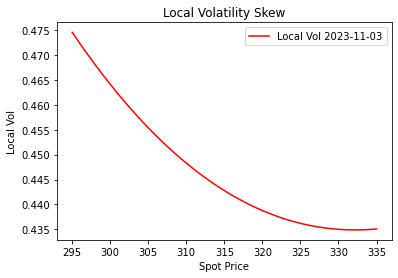

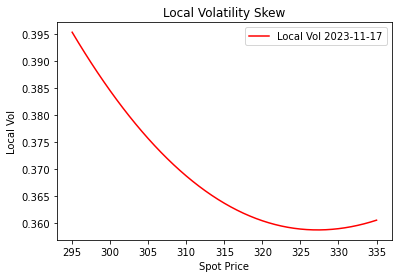

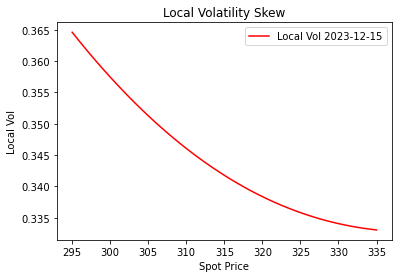

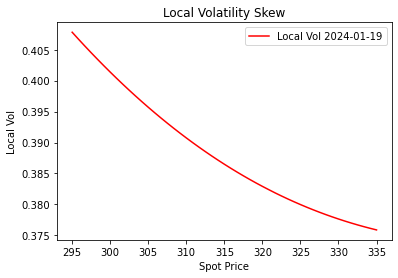

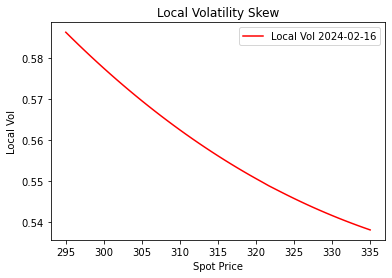

In [10]:
x_axis = np.linspace(strikes[-1][0] - 5, strikes[-1][-1] + 5, 49)

for t in range(len(tenors)) :
  plt.title("Local Volatility Skew")
  plt.ylabel("Local Vol")
  plt.xlabel("Spot Price")
  plt.plot(x_axis, local_vol(vol_tenors[t], x_axis), color="red", label="Local Vol " + str(tenors[t]))
  plt.legend(loc="upper right")
  plt.show()

## Monte-Carlo LV Pricer
Let us reprice the market Vanilla Options with the Local Volatility model and study the quality of our calibration. \\
We use the Monte-Carlo method :     
$$
S_{t+dt} = S_{t} \times exp\left(\left(r_t - \frac{\sigma^2(t, S_t)}{2}\right) dt + \sigma(t, S_t) dW_t \right)
$$

In [11]:
class lov_vol_mc :
  """
  Monte-Carlo LV Pricer
  """
  def __init__(self, Nsimul=5*10**5, Nsteps=100) :
    # Init method
    self.Nsimul = Nsimul
    self.Nsteps = Nsteps

  def setPath(self, T) :
    """
    Monte-Carlo Simulation : Nsteps x Nsimul
    """
    # Generate random N(0,1)
    normal = np.random.normal(0, 1, (self.Nsteps, self.Nsimul))

    # Time vector
    dt = T / self.Nsteps
    t = np.linspace(0, T, num=self.Nsteps+1, endpoint=True)
    sqrt_dt = math.sqrt(dt)

    # S array (time x simulations)
    self.S = np.empty(shape=(self.Nsteps + 1, self.Nsimul))
    self.S[0,:] = S0

    # Local vol interpolation params
    n_interp = 101
    n_stdev = 5
    prev_fwd = S0

    for j in range(self.Nsteps) :
      # S points for local vol interpolation computed for each time step
      fwd = S0 * np.exp(zc_rates_interp(t[j+1]) * t[j+1])
      factor = math.exp(n_stdev * implied_vol_sabr(t[j+1], fwd) * math.sqrt(t[j+1]))
      Smax = fwd * factor
      Smin = fwd / factor
      Sinterp = np.linspace(Smin, Smax, num=n_interp, endpoint=True)

      # Compute local vol interpolation
      local_vol_interp = interp1d(Sinterp, local_vol(t[j], Sinterp), kind='cubic', fill_value="extrapolate")

      # Local_vol(t[j], S[j,:])
      sigma = local_vol_interp(self.S[j,:]) # Interpolation is much faster than sigma = local_vol(t[j], S[j,:])

      # Forward ZC rate : zc_r(t, t+dt) ~ r(t)
      mu = math.log(fwd / prev_fwd) / dt
      prev_fwd = fwd

      # Spot simulations from t to t + dt
      self.S[j+1,:] = self.S[j,:] * np.exp( (mu - 0.5 * sigma**2) * dt + sigma * sqrt_dt * normal[j,:])


  def vanilla_price(self, T, K, flavor, r) :
      """
      Monte-Carlo Price : DF x Mean(PayOff)
      """
      df = math.exp(-r * T)
      phi = 1 if flavor.upper() == "CALL" else -1
      payoff = np.maximum(phi * (self.S[-1,:] - K) , 0)
      return df * np.mean(payoff)

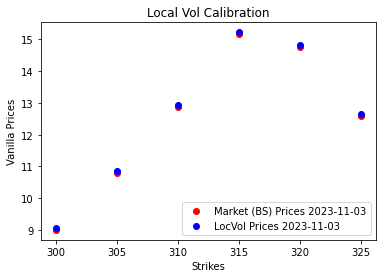

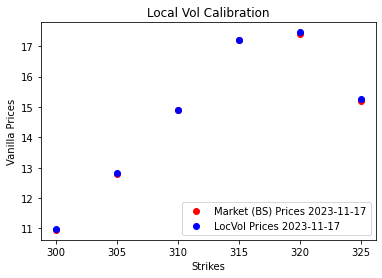

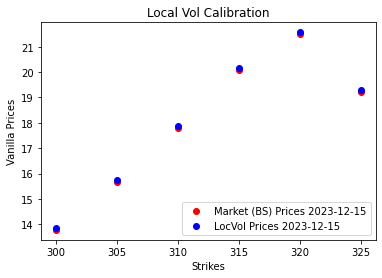

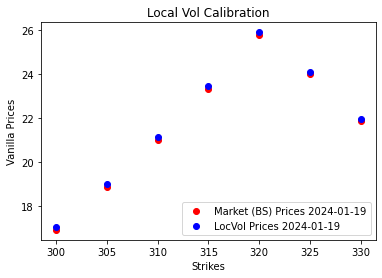

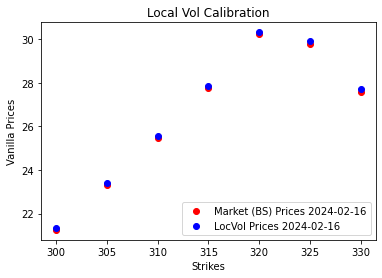

In [12]:
mc_pricer = lov_vol_mc()
mc_prices = []
for t in range(len(vol_tenors)) :
  mc_pricer.setPath(vol_tenors[t])
  r = math.log(fwds[t] / S0) / vol_tenors[t]
  mc_prices_tenor = []
  for k in range(len(strikes[t])):
    mc_prices_tenor.append(mc_pricer.vanilla_price(vol_tenors[t], strikes[t][k], flavors[t][k], r))
  mc_prices.append(mc_prices_tenor)
  plt.title("Local Vol Calibration")
  plt.ylabel("Vanilla Prices")
  plt.xlabel("Strikes")
  plt.scatter(strikes[t], prices[t], color="red", label="Market (BS) Prices " + str(tenors[t]))
  plt.scatter(strikes[t], mc_prices_tenor, color="blue", label="LocVol Prices " + str(tenors[t]))
  plt.legend(loc="lower right")
  plt.show()


In [13]:
calib_errors = []

print("Market Prices vs LocVol Prices :")
print("-------------------------------------")

for t in range(len(vol_tenors)) :
  for k in range(len(strikes[t])):
    print("Maturity : " + str(tenors[t]))
    print("Strike :", strikes[t][k])
    print("LocVol Price : ", round(mc_prices[t][k], 3))
    print("Market (BS) Price : ", round(prices[t][k], 3))
    calib_errors.append(abs(mc_prices[t][k] / prices[t][k] - 1))
    print("Err : " + str(round(100 * abs(calib_errors[-1]), 2)) + "%" )
    print("-------------------------------------")


Market Prices vs LocVol Prices :
-------------------------------------
Maturity : 2023-11-03
Strike : 300
LocVol Price :  9.064
Market (BS) Price :  9
Err : 0.71%
-------------------------------------
Maturity : 2023-11-03
Strike : 305
LocVol Price :  10.868
Market (BS) Price :  10.8
Err : 0.63%
-------------------------------------
Maturity : 2023-11-03
Strike : 310
LocVol Price :  12.921
Market (BS) Price :  12.875
Err : 0.35%
-------------------------------------
Maturity : 2023-11-03
Strike : 315
LocVol Price :  15.227
Market (BS) Price :  15.175
Err : 0.34%
-------------------------------------
Maturity : 2023-11-03
Strike : 320
LocVol Price :  14.824
Market (BS) Price :  14.775
Err : 0.33%
-------------------------------------
Maturity : 2023-11-03
Strike : 325
LocVol Price :  12.642
Market (BS) Price :  12.6
Err : 0.33%
-------------------------------------
Maturity : 2023-11-17
Strike : 300
LocVol Price :  10.97
Market (BS) Price :  10.95
Err : 0.18%
---------------------------

In [19]:
calib_errors = np.array(calib_errors, dtype=object)
print("Number of the Calibration Instruments : " + str(sum(len(k) for k in strikes)))
print("Maximum of the Calibration Errors : " + str(round(100 * np.max(calib_errors), 2)) + "%")
print("Minimum of the Calibration Errors : " + str(round(100 * np.min(calib_errors), 2)) + "%")
print("Average of the Calibration Errors : " + str(round(100 * np.mean(calib_errors), 2)) + "%")
print("Number of the Calibration Errors above 1% : ", np.sum(np.abs(calib_errors) >= 0.01))
print("Number of the Calibration Errors below 1% : ", np.sum(np.abs(calib_errors) < 0.01))

Number of the Calibration Instruments : 32
Maximum of the Calibration Errors : 0.76%
Minimum of the Calibration Errors : 0.04%
Average of the Calibration Errors : 0.41%
Number of the Calibration Errors above 1% :  0
Number of the Calibration Errors below 1% :  32
